In [1]:
# LSTM ?
# RNN ?
# find and load the data
# closing price
# how much price move with previos and current closing price
# fit with previous candle to current
# closing price

# --------------------------------------------------------------------
# Bitcoin price prediction
# 1. Find dataset with bitcoin price
# 2. Show Bitcoin chart
# 3. Convert data into Keras data format to feed model
# 4. devide data for train and test in a special way get data which is last month old for testing to know how accurate model is
# 5. difference beetween price???
# 6. try with standart metrix



In [2]:
import scaler
import yfinance as yf

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split


In [3]:
# 1. Find dataset with bitcoin price

# Завантажуємо дані Bitcoin (BTC-USD — біткоїн до долара)
data = yf.download('BTC-USD', start='2020-01-01', end="2025-10-10", interval='1d')
data_test = yf.download('BTC-USD', start='2025-01-10', interval='1d')

normalizer = 1000000

# Переглядаємо перші рядки
print(data.head())
print(data.tail())


C:\Users\Denys\AppData\Local\Temp\ipykernel_2996\449697881.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('BTC-USD', start='2020-01-01', end="2025-10-10", interval='1d')
[*********************100%***********************]  1 of 1 completed
C:\Users\Denys\AppData\Local\Temp\ipykernel_2996\449697881.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_test = yf.download('BTC-USD', start='2025-01-10', interval='1d')
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open       Volume
Ticker          BTC-USD      BTC-USD      BTC-USD      BTC-USD      BTC-USD
Date                                                                       
2020-01-01  7200.174316  7254.330566  7174.944336  7194.892090  18565664997
2020-01-02  6985.470215  7212.155273  6935.270020  7202.551270  20802083465
2020-01-03  7344.884277  7413.715332  6914.996094  6984.428711  28111481032
2020-01-04  7410.656738  7427.385742  7309.514160  7345.375488  18444271275
2020-01-05  7411.317383  7544.497070  7400.535645  7410.451660  19725074095
Price               Close           High            Low           Open  \
Ticker            BTC-USD        BTC-USD        BTC-USD        BTC-USD   
Date                                                                     
2025-10-05  123513.476562  125559.210938  122191.960938  122419.671875   
2025-10-06  124752.531250  126198.070312  123196.046875  123510.453125   
2025-10-07  121451.382

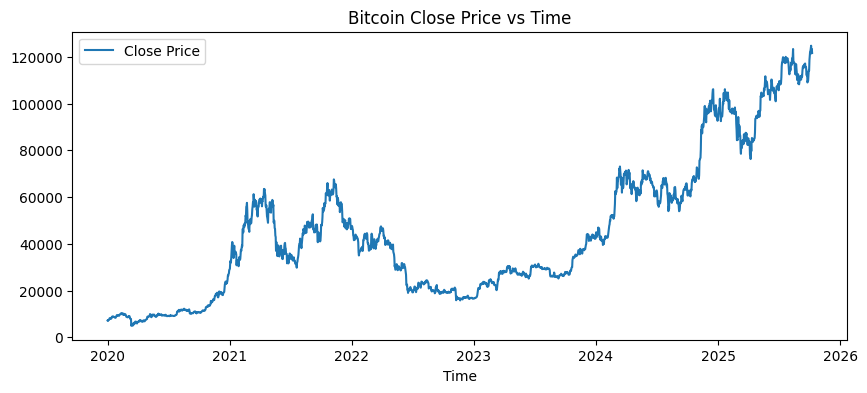

In [4]:
# 2. Show Bitcoin chart
plt.figure(figsize=(10,4))
plt.plot(data["Close"], label='Close Price')
plt.legend()
plt.title("Bitcoin Close Price vs Time")
plt.xlabel("Time")
plt.show()

In [10]:
# 3. Convert data into Keras data format to feed model

def make_dataset(series, seq_len=50, pred_len=7, step=1):
    X, y = [], []
    for i in range(0, len(series) - seq_len - pred_len, step):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len:i+seq_len+pred_len])
    X = np.array(X)
    y = np.array(y)

    #print(X.shape)
    # LSTM в Keras очікує форму (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y


In [69]:

seq_len = 50
pred_len = 5

np_data = np.asarray(data["Close"])
np_data = np_data / normalizer
X, y = make_dataset(np_data, seq_len=seq_len, pred_len=pred_len)



#print(X.shape)

In [70]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

#print(X_train.shape)
#print(X_test.shape)

In [71]:
# 4) Побудова моделі
model = models.Sequential([
    layers.Input(shape=(seq_len, 1)),
    layers.LSTM(64 * 2, return_sequences=False),  # 64 прихованих одиниць
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(pred_len)  # прогноз — одне значення
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,061 (301.02 KB)

 Trainable params: 77,061 (301.02 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 4.4236e-04 - mae: 0.0128 - val_loss: 2.0450e-05 - val_mae: 0.0035
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.7702e-05 - mae: 0.0031 - val_loss: 1.5792e-05 - val_mae: 0.0028
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.4668e-05 - mae: 0.0028 - val_loss: 1.6070e-05 - val_mae: 0.0032
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.5753e-05 - mae: 0.0029 - val_loss: 1.7275e-05 - val_mae: 0.0032
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.6467e-05 - mae: 0.0030 - val_loss: 1.2885e-05 - val_mae: 0.0025
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.3994e-05 - mae: 0.0028 - val_loss: 1.2214e-05 - val_mae: 0.0025
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.2719e-05 - mae: 0.0026 - val_loss: 1.2944e-05 - val_mae: 0.0026
Epoch 8/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.1847e-05 - mae: 0.0024 - val_loss: 1.1117e-05 - val_mae: 0.0023


In [73]:
np_data_test = np.asarray(data_test["Close"])
np_data_test = np_data_test / 1000000



X_t, y_t = make_dataset(np_data_test, seq_len=seq_len, pred_len=pred_len)


y_pred = model.predict(X_t)


#y_test_inv = y_test.reshape(-1, pred_len)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Test MSE: 0.00001, Test MAE: 0.00295


C:\Users\Denys\AppData\Local\Temp\ipykernel_2996\2316250393.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


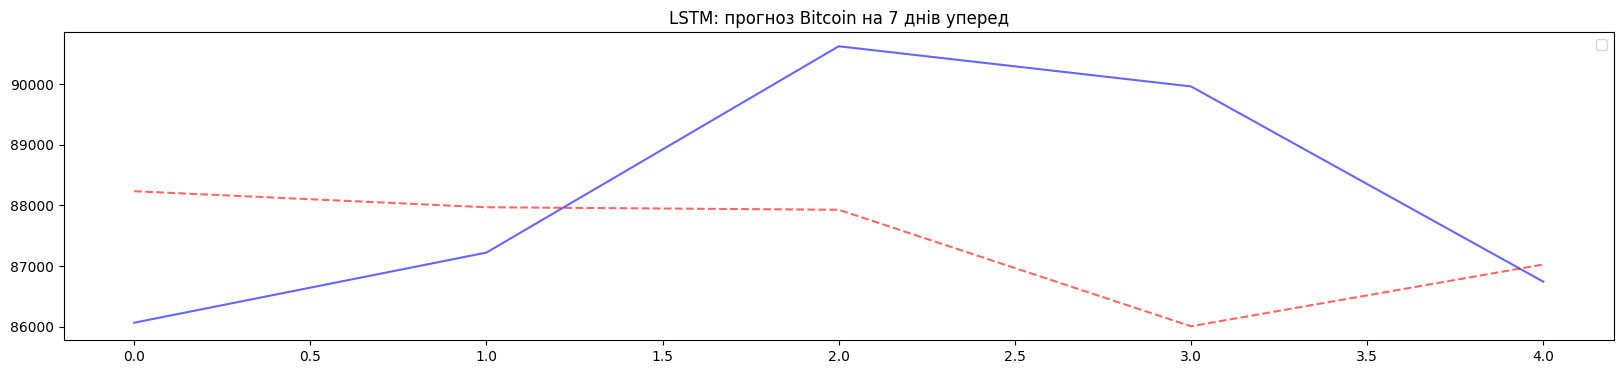

In [74]:
# 6) Оцінка та прогноз
test_loss, test_mae = model.evaluate(X_t, y_t, verbose=0)
print(f"Test MSE: {test_loss:.5f}, Test MAE: {test_mae:.5f}")


plt.figure(figsize=(20,4))

i = 2
plt.plot(y_t[i] * normalizer , color='blue', alpha=0.6)
plt.plot(y_pred[i] * normalizer , color='red', linestyle='--', alpha=0.6)
plt.title('LSTM: прогноз Bitcoin на 7 днів уперед')
plt.legend()
plt.show()

Test MSE: 0.00001, Test MAE: 0.00295


C:\Users\Denys\AppData\Local\Temp\ipykernel_2996\1082706500.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


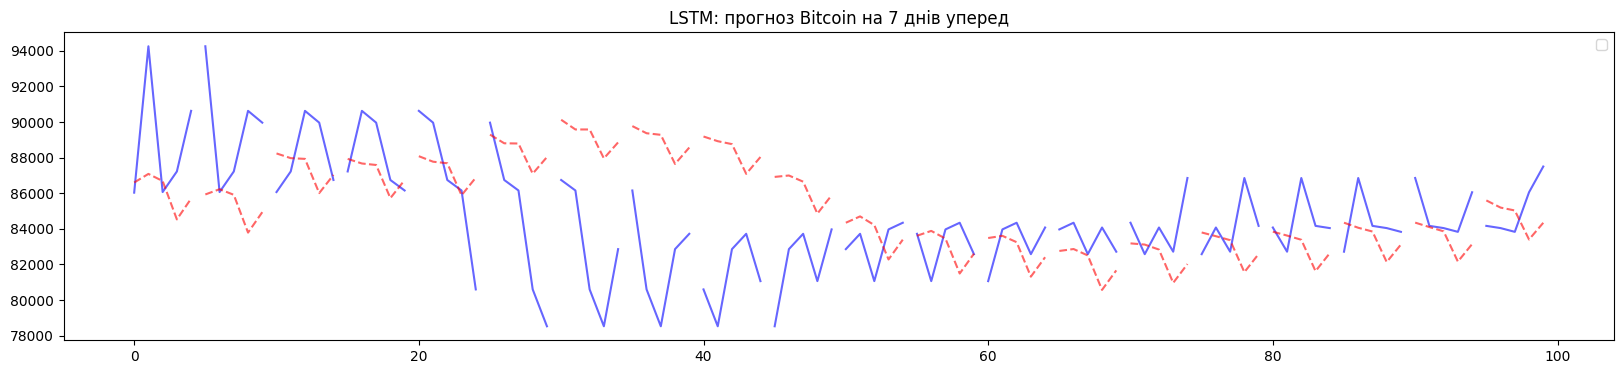

In [75]:
# 6) Оцінка та прогноз
test_loss, test_mae = model.evaluate(X_t, y_t, verbose=0)
print(f"Test MSE: {test_loss:.5f}, Test MAE: {test_mae:.5f}")


plt.figure(figsize=(20,4))

num_blocks_to_plot = 20  # скільки прогнозів малювати
for i in range(num_blocks_to_plot):
    plt.plot(range(i * pred_len, i * pred_len + pred_len), y_t[i] * normalizer , color='blue', alpha=0.6)
    plt.plot(range(i * pred_len, i * pred_len + pred_len), y_pred[i] * normalizer , color='red', linestyle='--', alpha=0.6)
plt.title('LSTM: прогноз Bitcoin на 7 днів уперед')
plt.legend()
plt.show()

Test MSE: 0.00002, Test MAE: 0.00353
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


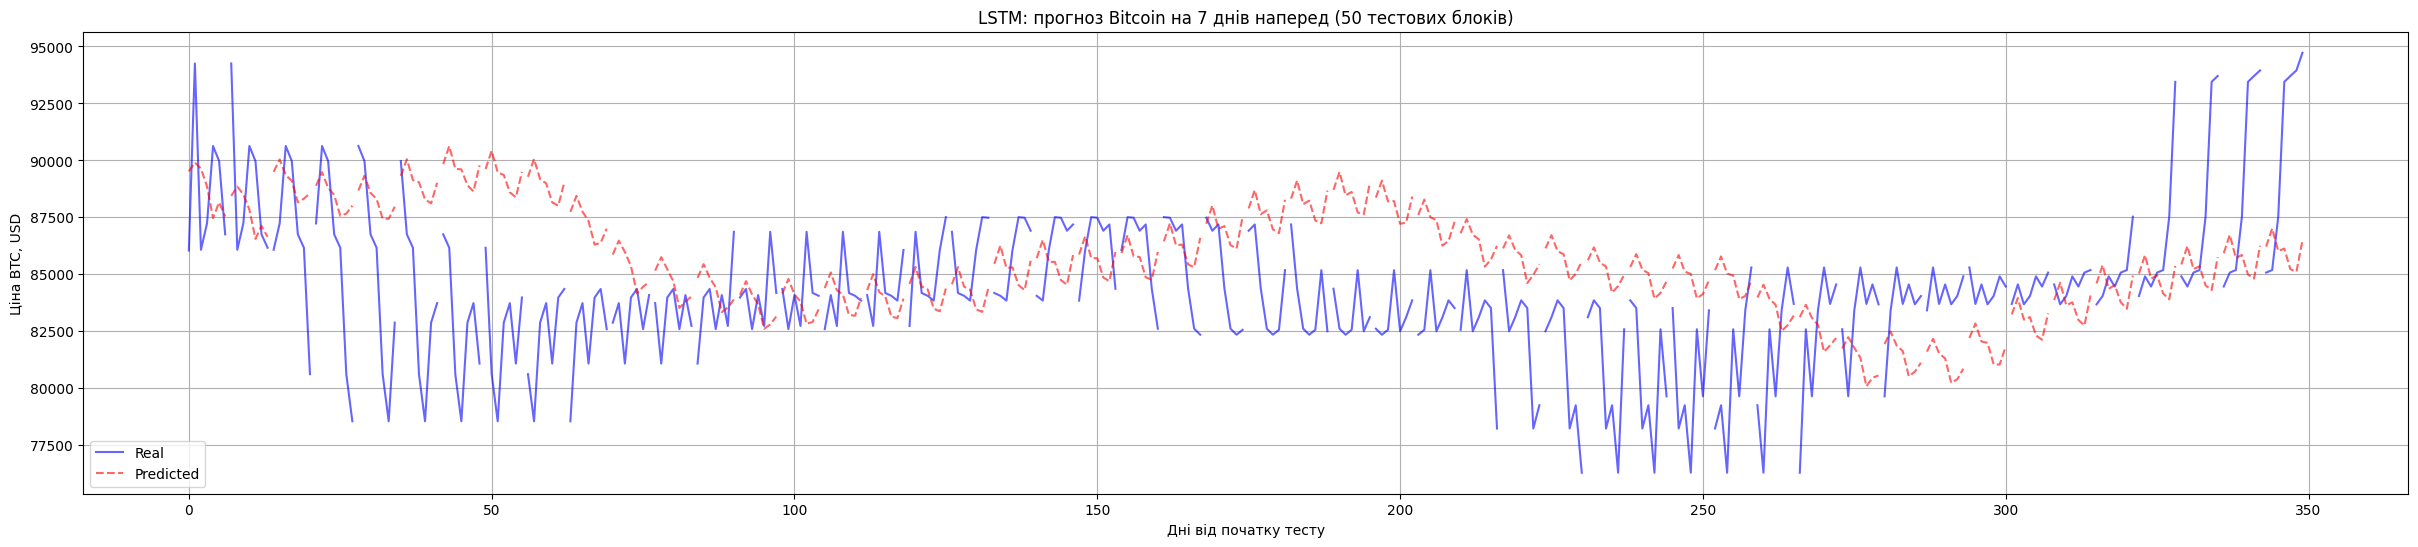

In [43]:
# 6) Оцінка та прогноз
test_loss, test_mae = model.evaluate(X_t, y_t, verbose=0)
print(f"Test MSE: {test_loss:.5f}, Test MAE: {test_mae:.5f}")

# Прогноз на всі тестові дані
y_pred = model.predict(X_t)

# Відновлення масштабу
y_t_inv = y_t * normalizer
y_pred_inv = y_pred * normalizer

# Підготовка для повного графіка
plt.figure(figsize=(30,6))  # збільшений розмір графіка (ширше і вище)

# Малюємо кожен блок прогнозу (наприклад, 7 днів) для кількох тестових зразків
num_blocks_to_plot = 10  # скільки прогнозів малювати
for i in range(num_blocks_to_plot):
    plt.plot(range(i*7, i*7+7), y_t_inv[i], color='blue', alpha=0.6)
    plt.plot(range(i*7, i*7+7), y_pred_inv[i], color='red', linestyle='--', alpha=0.6)

plt.title('LSTM: прогноз Bitcoin на 7 днів наперед (50 тестових блоків)')
plt.xlabel('Дні від початку тесту')
plt.ylabel('Ціна BTC, USD')
plt.legend(['Real', 'Predicted'])
plt.grid(True)
plt.show()


In [ ]:
#data_test["Predicted Price"] =

Test MSE: 0.00002, Test MAE: 0.00353
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


ValueError: x and y can be no greater than 2D, but have shapes (200,) and (200, 7, 1)

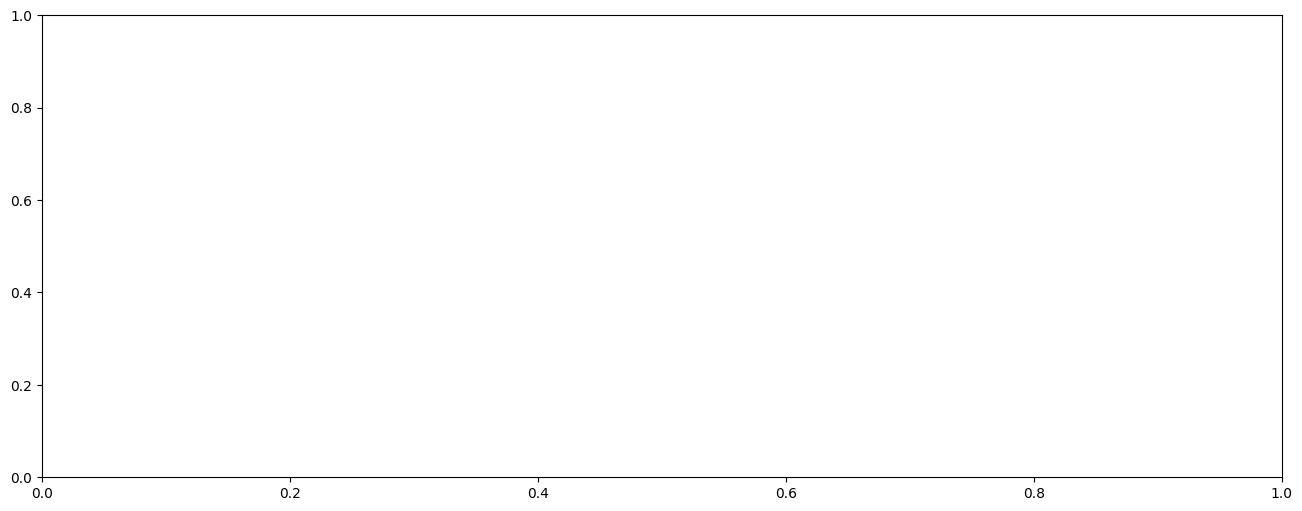

In [18]:
#


In [ ]:
# lets try to predict price for a week ahead


